In [ ]:
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast

cleaned_train = pd.read_csv("/content/drive/MyDrive/cleaned_train_final.csv")

cleaned_train['ec_list'] = cleaned_train['ec_list'].apply(ast.literal_eval)

X = cleaned_train["Sequence"]

mlb = MultiLabelBinarizer()

y = mlb.fit_transform(cleaned_train['ec_list'])

print("class list:", mlb.classes_)
print("y shape:", y.shape)

class list: ['1.1' '1.10' '1.11' '1.12' '1.13' '1.14' '1.15' '1.16' '1.17' '1.18'
 '1.19' '1.2' '1.20' '1.21' '1.23' '1.3' '1.4' '1.5' '1.6' '1.7' '1.8'
 '1.9' '1.97' '2.1' '2.10' '2.2' '2.3' '2.4' '2.5' '2.6' '2.7' '2.8' '2.9'
 '3.1' '3.10' '3.11' '3.12' '3.13' '3.2' '3.3' '3.4' '3.5' '3.6' '3.7'
 '3.8' '3.9' '4.1' '4.2' '4.3' '4.4' '4.5' '4.6' '4.7' '4.8' '4.98' '4.99'
 '5.1' '5.2' '5.3' '5.4' '5.5' '5.6' '5.99' '6.1' '6.2' '6.3' '6.4' '6.5'
 '6.6' '6.7' '7.1' '7.2' '7.3' '7.4' '7.5' '7.6']
y shape: (234046, 76)


In [ ]:
# ✅ 1. 라이브러리 로드
import torch
import esm
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import ast

# ✅ 2. 데이터 로딩 및 전처리
df = pd.read_csv("/content/drive/MyDrive/cleaned_train_final.csv")
df['ec_list'] = df['ec_list'].apply(ast.literal_eval)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['ec_list'])

X_train, X_test, y_train, y_test = train_test_split(df['Sequence'].tolist(), y, test_size=0.2, random_state=42)


In [ ]:
def truncate_seq(seq, max_len=512):
    return seq[:max_len]

# 적용
X_train = [truncate_seq(s) for s in X_train]
X_test = [truncate_seq(s) for s in X_test]


In [ ]:

# ✅ 3. ESM2 로드 및 임베딩 함수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=120, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((320,), eps=1e-05, elementwis

In [ ]:
def compute_embeddings(seqs, batch_size=64):
    all_embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(seqs), batch_size)):
            batch_seqs = [(str(i), seq) for i, seq in enumerate(seqs[i:i+batch_size])]
            _, _, batch_tokens = batch_converter(batch_seqs)
            batch_tokens = batch_tokens.to(device)
            results = model(batch_tokens, repr_layers=[6], return_contacts=False)
            emb = results["representations"][6][:, 0, :].cpu().numpy()  # CLS token
            all_embeddings.append(emb)
    return np.vstack(all_embeddings)

In [ ]:
# ✅ 4. 임베딩 추출
X_train_emb = compute_embeddings(X_train, batch_size=64)
X_test_emb  = compute_embeddings(X_test, batch_size=64)

100%|██████████| 732/732 [41:26<00:00,  3.40s/it]


In [ ]:
# 👉 저장
np.save("/content/X_train_emb.npy", X_train_emb)
np.save("/content/X_test_emb.npy", X_test_emb)
np.save("/content/y_train.npy", y_train)
np.save("/content/y_test.npy", y_test)



In [ ]:
#(원하면 csv로도 저장 가능)
pd.DataFrame(X_train_emb).to_csv("/content/X_train_emb.csv", index=False)
pd.DataFrame(X_test_emb).to_csv("/content/X_test_emb.csv", index=False)


In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import ast

In [ ]:
X_train_emb = np.load("/content/X_train_emb.npy")
X_test_emb = np.load("/content/X_test_emb.npy")
y_train = np.load("/content/y_train.npy")
y_test = np.load("/content/y_test.npy")


In [ ]:
X_train_emb.shape, X_test_emb.shape

((187236, 320), (46810, 320))

In [ ]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# 1. 모델 정의
mlp = MLPClassifier(
    hidden_layer_sizes=(256,),
    max_iter=200,
    early_stopping=True,           # 내부적으로 검증 손실도 기록
    validation_fraction=0.2,       # 10%를 validation에 사용
    random_state=42,
    verbose=False
)

# 2. 학습
mlp.fit(X_train_emb, y_train)




MLPClassifier(early_stopping=True, hidden_layer_sizes=(256,), random_state=42,
              validation_fraction=0.2)

In [ ]:
print("Actual number of epochs run:", mlp.n_iter_)

Actual number of epochs run: 117


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

param_grid = {
    'hidden_layer_sizes': [(256,), (512,), (256, 128), (512, 256)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [0.001, 0.005],
}

mlp = MLPClassifier(max_iter=117, random_state=42)

clf = GridSearchCV(mlp, param_grid, scoring='f1_micro', cv=3, verbose=2, n_jobs=-1)
clf.fit(X_train_emb, y_train)

print("Best params:", clf.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [ ]:
y_pred2 = clf.predict(X_test_emb)

print("🔹 Micro F1-score:", f1_score(y_test, y_pred2, average='micro'))
print("🔹 Macro F1-score:", f1_score(y_test, y_pred2, average='macro'))

🔹 Micro F1-score: 0.8729685051203332
🔹 Macro F1-score: 0.752739214860455


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ✅ 5. MLPClassifier 훈련
mlp = MLPClassifier(hidden_layer_sizes=(512, 256),activation='relu', alpha=0.0001, learning_rate_init = 0.001, max_iter=117, random_state=42, verbose=True)
mlp.fit(X_train_emb, y_train)

# ✅ 6. 예측 및 평가
y_pred = mlp.predict(X_test_emb)

print("🔹 Micro F1-score:", f1_score(y_test, y_pred, average='micro'))
print("🔹 Macro F1-score:", f1_score(y_test, y_pred, average='macro'))

Iteration 1, loss = 3.87127261
Iteration 2, loss = 2.59759588
Iteration 3, loss = 2.17573028
Iteration 4, loss = 1.89407905
Iteration 5, loss = 1.68789093
Iteration 6, loss = 1.53053647
Iteration 7, loss = 1.41128002
Iteration 8, loss = 1.30944390
Iteration 9, loss = 1.23041889
Iteration 10, loss = 1.15517779
Iteration 11, loss = 1.09966978
Iteration 12, loss = 1.04698339
Iteration 13, loss = 1.00162377
Iteration 14, loss = 0.96292152
Iteration 15, loss = 0.92638696
Iteration 16, loss = 0.89280439
Iteration 17, loss = 0.86477473
Iteration 18, loss = 0.83703260
Iteration 19, loss = 0.80816827
Iteration 20, loss = 0.78749639
Iteration 21, loss = 0.76448120
Iteration 22, loss = 0.74506143
Iteration 23, loss = 0.72544187
Iteration 24, loss = 0.70943939
Iteration 25, loss = 0.68949085
Iteration 26, loss = 0.67744809
Iteration 27, loss = 0.66005905
Iteration 28, loss = 0.64651671
Iteration 29, loss = 0.63240169
Iteration 30, loss = 0.62195572
Iteration 31, loss = 0.60505587
Iteration 32, los

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (117) reached and the optimization hasn't converged yet.
  warnings.warn(


🔹 Micro F1-score: 0.8856928620524464
🔹 Macro F1-score: 0.7731769393002432


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
f1_micro_full = f1_score(y_test, y_pred, average='micro')
f1_macro_full = f1_score(y_test, y_pred, average='macro')


In [ ]:
f1_micro_full =0.8856928620524464
f1_macro_full = 0.7731769393002432

In [ ]:
# Train MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', alpha=0.0001,
                    learning_rate_init=0.001, max_iter=117, random_state=42, verbose=True)
mlp.fit(X_train_emb, y_train)

# Predict and Evaluate (All Classes)
y_pred = mlp.predict(X_test_emb)

print("🔹 Micro F1-score:", f1_score(y_test, y_pred, average='micro'))
print("🔹 Macro F1-score:", f1_score(y_test, y_pred, average='macro'))

#ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ#

# Calculate class frequencies and define rare classes
class_counts = y_train.sum(axis=0)
class_ratios = class_counts / y_train.shape[0]
rare_classes = np.where(class_counts < 100)[0]

# Remove rare classes (drop corresponding columns)
y_train_filtered = np.delete(y_train, rare_classes, axis=1)
y_test_filtered  = np.delete(y_test,  rare_classes, axis=1)

# Remove samples with all-zero labels (train set)
train_valid_idx = y_train_filtered.sum(axis=1) > 0
X_train_filtered = X_train_emb[train_valid_idx]
y_train_filtered = y_train_filtered[train_valid_idx]

# Remove samples with all-zero labels (test set)
test_valid_idx = y_test_filtered.sum(axis=1) > 0
X_test_filtered = X_test_emb[test_valid_idx]
y_test_filtered = y_test_filtered[test_valid_idx]

# Retrain MLPClassifier on filtered data
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', alpha=0.0001,
                    learning_rate_init=0.001, max_iter=117, random_state=42, verbose=True)
mlp.fit(X_train_filtered, y_train_filtered)

# Predict and Evaluate (Filtered Classes)
y_pred2 = mlp.predict(X_test_filtered)

print("🔹 Micro F1-score:", f1_score(y_test_filtered, y_pred2, average='micro'))
print("🔹 Macro F1-score:", f1_score(y_test_filtered, y_pred2, average='macro'))


In [ ]:
# ✅ 2. 클래스별 비율 계산 및 희귀 클래스 정의
class_counts = y_train.sum(axis=0)
class_ratios = class_counts / y_train.shape[0]
rare_classes = np.where(class_counts < 100)[0]

# ✅ 3. 희귀 클래스 제거 (column 제거)
y_train_filtered = np.delete(y_train, rare_classes, axis=1)
y_test_filtered  = np.delete(y_test,  rare_classes, axis=1)

# ✅ 4. 모든 라벨이 0인 샘플 제거 (train 기준)
train_valid_idx = y_train_filtered.sum(axis=1) > 0
X_train_filtered = X_train_emb[train_valid_idx]
y_train_filtered = y_train_filtered[train_valid_idx]

# ✅ 5. test에서도 모든 라벨이 0인 샘플 제거
test_valid_idx = y_test_filtered.sum(axis=1) > 0
X_test_filtered = X_test_emb[test_valid_idx]
y_test_filtered = y_test_filtered[test_valid_idx]

# ✅ 6. 최종 확인
print("X_train_filtered:", X_train_filtered.shape)
print("y_train_filtered:", y_train_filtered.shape)
print("X_test_filtered:", X_test_filtered.shape)
print("y_test_filtered:", y_test_filtered.shape)

X_train_filtered: (186768, 320)
y_train_filtered: (186768, 58)
X_test_filtered: (46699, 320)
y_test_filtered: (46699, 58)


In [ ]:
# ✅ 5. MLPClassifier 훈련
mlp = MLPClassifier(hidden_layer_sizes=(512, 256),activation='relu', alpha=0.0001, learning_rate_init = 0.001, max_iter=117, random_state=42, verbose=True)
mlp.fit(X_train_filtered, y_train_filtered)

# ✅ 6. 예측 및 평가
y_pred2 = mlp.predict(X_test_filtered)

print("🔹 Micro F1-score:", f1_score(y_test_filtered, y_pred2, average='micro'))
print("🔹 Macro F1-score:", f1_score(y_test_filtered, y_pred2, average='macro'))

Iteration 1, loss = 3.68709745
Iteration 2, loss = 2.52112979
Iteration 3, loss = 2.11839287
Iteration 4, loss = 1.85319909
Iteration 5, loss = 1.66631092
Iteration 6, loss = 1.51325527
Iteration 7, loss = 1.40482208
Iteration 8, loss = 1.30891463
Iteration 9, loss = 1.22637339
Iteration 10, loss = 1.16413538
Iteration 11, loss = 1.10589013
Iteration 12, loss = 1.05547861
Iteration 13, loss = 1.01340337
Iteration 14, loss = 0.97763812
Iteration 15, loss = 0.94095454
Iteration 16, loss = 0.90650914
Iteration 17, loss = 0.87932238
Iteration 18, loss = 0.85211067
Iteration 19, loss = 0.82640623
Iteration 20, loss = 0.80324320
Iteration 21, loss = 0.78076574
Iteration 22, loss = 0.76209817
Iteration 23, loss = 0.74033952
Iteration 24, loss = 0.72422497
Iteration 25, loss = 0.70800514
Iteration 26, loss = 0.68988865
Iteration 27, loss = 0.67792680
Iteration 28, loss = 0.66577899
Iteration 29, loss = 0.64759864
Iteration 30, loss = 0.63572334
Iteration 31, loss = 0.62280852
Iteration 32, los

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (117) reached and the optimization hasn't converged yet.
  warnings.warn(


🔹 Micro F1-score: 0.8835597012573662
🔹 Macro F1-score: 0.8481420392350699


/tmp/ipython-input-10-4162216878.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center')


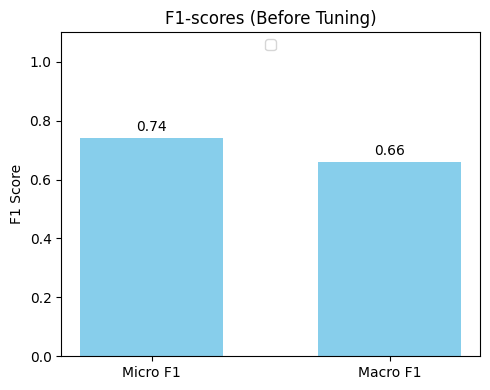

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Data
labels = ['Micro F1', 'Macro F1']
full_scores = [0.74, 0.66]

# ✅ 더 간격이 좁고 예쁘게
x = np.arange(len(labels))  # [0, 1]
width = 0.6  # 더 넓은 막대 폭

fig, ax = plt.subplots(figsize=(5, 4))
rects = ax.bar(x, full_scores, width=width, color='skyblue')

# ✅ 축 설정
ax.set_ylabel('F1 Score')
ax.set_ylim(0, 1.1)
ax.set_title('F1-scores (Before Tuning)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

# ✅ 값 레이블 추가
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

plt.tight_layout()
plt.show()


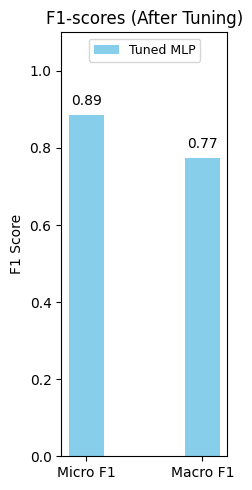

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = ['Micro F1', 'Macro F1']
scores = [0.8857, 0.7732]

# 좌우 벽에서 떨어뜨리기 위해 위치 조정
x = np.arange(len(labels)) + 10  # 살짝 오른쪽 이동
width = 0.3

fig, ax = plt.subplots(figsize=(2.5, 5))
rects = ax.bar(x, scores, width=width, color='skyblue', label='Tuned MLP')

# 축 설정
ax.set_ylabel('F1 Score')
ax.set_ylim(0, 1.1)
ax.set_title('F1-scores (After Tuning)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', fontsize=9)

# 막대 위 숫자 라벨
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)
plt.tight_layout()
plt.show()


In [ ]:
f1_micro_remove = f1_score(y_test_filtered, y_pred2, average='micro')
f1_macro_remove = f1_score(y_test_filtered, y_pred2, average='macro')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

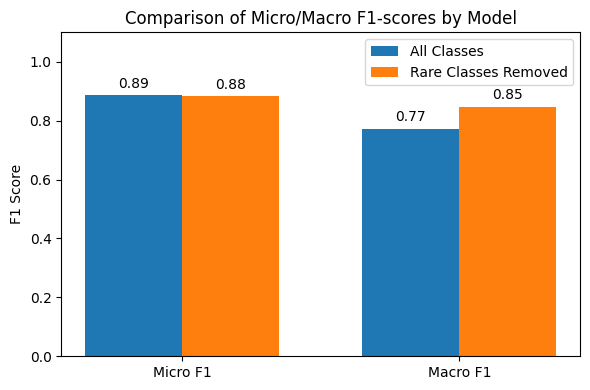

In [ ]:
# ✅ Bar chart data
labels = ['Micro F1', 'Macro F1']
full_scores = [f1_micro_full, f1_macro_full]
filtered_scores = [f1_micro_remove, f1_macro_remove]

x = np.arange(len(labels))  # [0, 1]
width = 0.35  # bar width

# ✅ Plotting
fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(x - width/2, full_scores, width, label='All Classes')
rects2 = ax.bar(x + width/2, filtered_scores, width, label='Rare Classes Removed')

# ✅ Labels and title
ax.set_ylabel('F1 Score')
ax.set_ylim(0, 1.1)
ax.set_title('Comparison of Micro/Macro F1-scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ✅ Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3pt above bar
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [ ]:
esm_2_f1_micro =0.83
esm_2_f1_macro = 0.74
rf_f1_micro = 0.68
rf_f1_macro = 0.49
mlp_f1_micro =0.89
mlp_f1_macro = 0.77

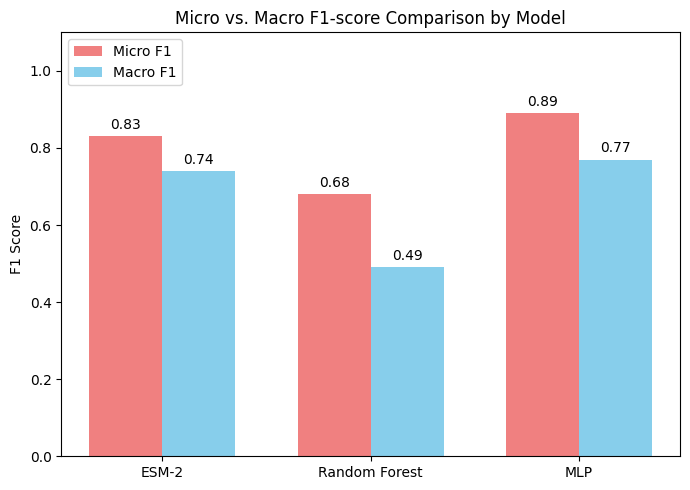

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ F1 Scores
models = ['ESM-2', 'Random Forest', 'MLP']
micro_scores = [0.83, 0.68, 0.89]
macro_scores = [0.74, 0.49, 0.77]

x = np.arange(len(models))  # [0, 1, 2]
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))

# ✅ Left: Micro F1
rects1 = ax.bar(x - width/2, micro_scores, width, label='Micro F1', color='lightcoral')

# ✅ Right: Macro F1
rects2 = ax.bar(x + width/2, macro_scores, width, label='Macro F1', color='skyblue')

# ✅ Axis setup
ax.set_ylabel('F1 Score')
ax.set_title('Micro vs. Macro F1-score Comparison by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left')

# ✅ Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
